# Прогнозирование вероятности оттока клиентов фитнес-центра

**Описание проекта**   
В данном проекте использовано машинное обучение.   
Фитнес-центром была предоставлена база данных, на основе которой нами спрогнозирована вероятность оттока (на уровне следующего месяца) для каждого клиента;   
сформированы типичные портреты пользователей: выделены наиболее яркие группы, охарактеризованы их основные свойства;   проанализированы основные признаки, наиболее сильно влияющие на отток.  

**Задача** — Провести анализ и подготовить план действий по удержанию клиентов

**План работ:**

[1. Загрузка данных](#blok_1)  
[1.1. Откроем файл с данными и изучим общую информацию](#blok_11)  
[1.2. Описание данных](#blok_12)  

[2. Исследовательский анализ данных (EDA)](#blok_2)  
[2.1. Изучение признаков, средних значений и стандартных отклонений](#blok_21)  
[2.2. Средние значения признаков в двух группах ](#blok_22)  
[2.3. Столбчатые гистограммы и распределения признаков](#blok_23)  
[2.4. Матрица корреляций](#blok_24)  
[2.5. Выводы](#blok_25)  

[3. Модель прогнозирования оттока клиентов ](#blok_3)  
[3.1. Разбиение данных на обучающую и валидационную выборки](#blok_31)  
[3.2. Обучение моделей "Логистическая регрессия" и "Случайный лес"](#blok_32)  
[3.3. Оценка метрик и сравнение моделей](#blok_33)  

[4. Кластеризация клиентов](#blok_4)  
[4.1. Стандартизация данных](#blok_41)  
[4.2. Матрица расстояний и дендрограмма](#blok_42)  
[4.3. Кластеризации по алгоритму K-Means и прогнозирование кластеров клиентов](#blok_43)  
[4.4. Средние значения признаков для кластеров](#blok_44)  
[4.5. Распределения признаков для кластеров](#blok_45) 
[4.6. Доли оттока в кластерах](#blok_46) 
[4.7. Выводы](#blok_47) 

[5. Выводы](#blok_5)  
[5.1. Общие выводы](#blok_51)  
[5.2. Рекомендации](#blok_52)

## Загрузка данных  <a id='blok_1'></a>

### Откроем файл с данными и изучим общую информацию <a id='blok_11'></a>

In [1]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans



In [2]:
#Сформируем датасет
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#Чтобы часть столбцов в дальнейшем не скрывалась, настроим принудительное отображение
pd.set_option('display.max_columns', None)
#Установим ширину ячеек
pd.set_option("max_colwidth", 999)

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Описание данных <a id='blok_12'></a>

Фитнес-клуб предоставил сведения в csv-файлах.  
Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.  
Набор данных включает следующие поля:

**Данные клиента за предыдущий до проверки факта оттока месяц:**  
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент, в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA) <a id='blok_2'></a>

### Изучение признаков, средних значений и стандартных отклонений <a id='blok_21'></a>

Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения 

In [5]:
#Посмотрим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Отсутствующих признаков нет

In [6]:
#Изменим регистр названия столбцов
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [7]:
#Проверим наличие дубликатов 
print('Обнаружено дубликатов:', df.duplicated().sum())

Обнаружено дубликатов: 0


In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В целом, данные равномерные, стандартные отклонения не велики. Возможно будут выбросы в 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра. Интересные данные в Лафтайм: при средних 4мес, есть и те, кто занимается 2.5 года. При этом средняя частота посещений выше у тех, кто дольше является клиентом.  
Посмотрим данные детальнее.

### Средние значения признаков в двух группах  <a id='blok_22'></a>

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [9]:
#Сгруппируем по 'факт оттока в текущем месяце'
df.groupby('churn').mean().T.style

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


В полях "gender", "near_location", "partner" и др у нас бинарные значения признаков (0 - 1).  
Это значит, что чем ближе среднее значение к единице, тем больше количество клиентов с этим признаком (то есть он равен 1) и наоборот.

Так мы видим, что пол никак не влияет на уход клиента, а те, кому абонемент достался по партнерской программе более склонны к уходу.  
Большая часть клиентов (в обеих группах) живет/работает поблизости от фитнеса.  
К удивлению есть клиенты, телефоны которых неизвестны.  
У текущих клиентов абонементы с большей длительностью, а у бывших клиентов превалируют абонементы на 1 месяц.  
Текущие клиенты чаще посещают фитнес, больше ходят на групповые тренировки и приносят больше денег на сопутствующие услуги.


### Столбчатые гистограммы и распределения признаков <a id='blok_23'></a>

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

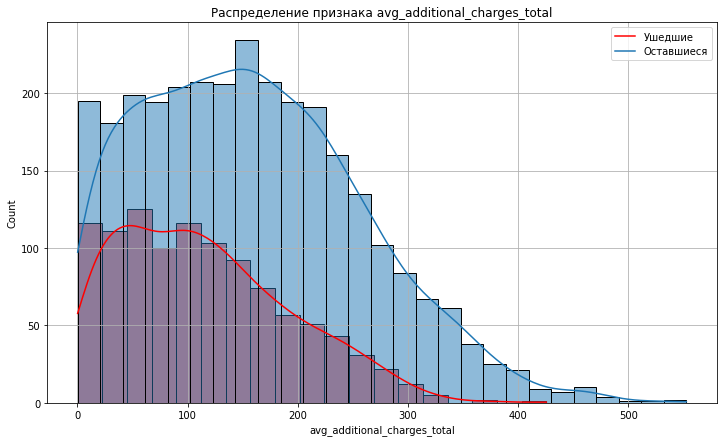

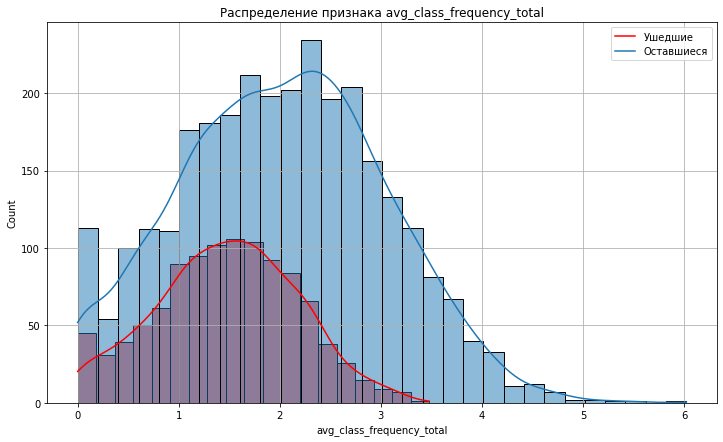

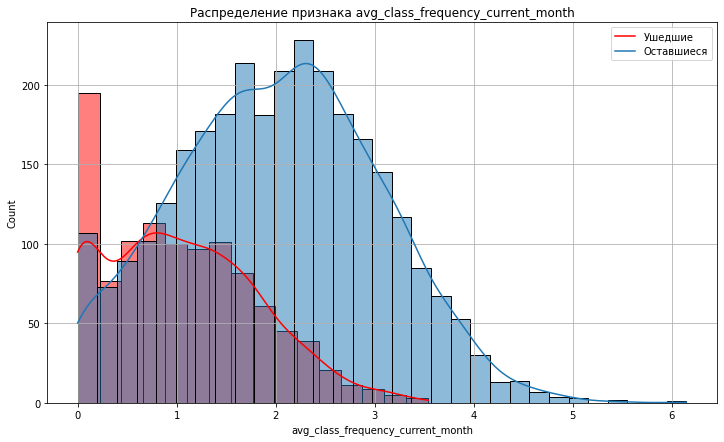

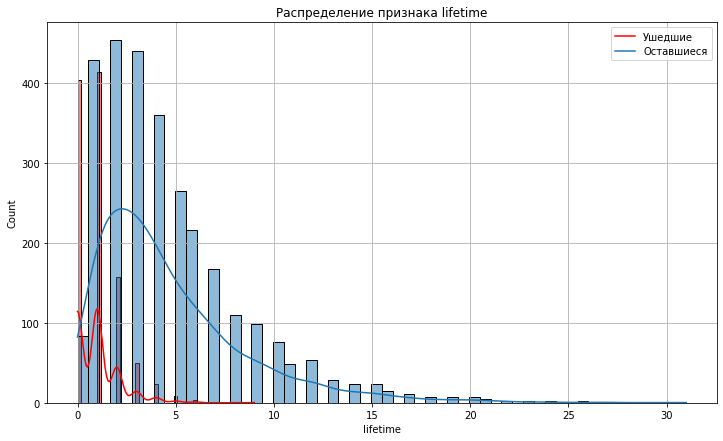

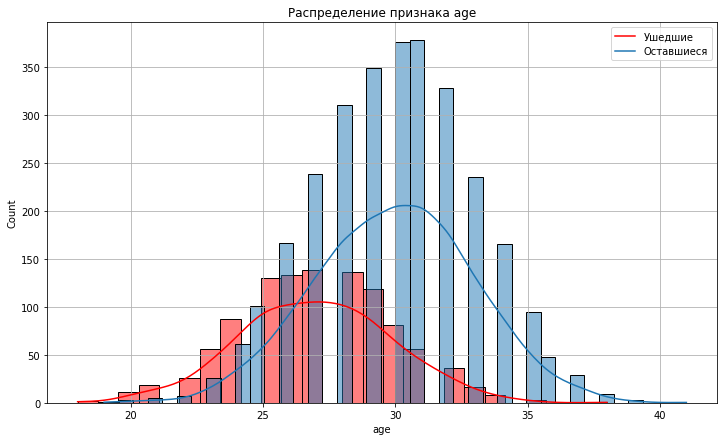

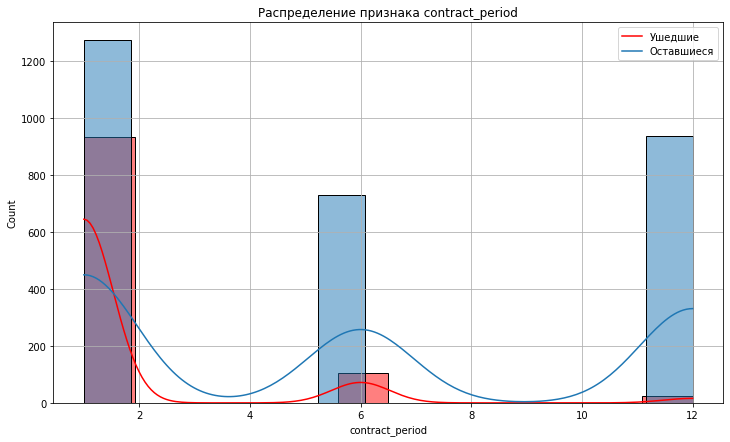

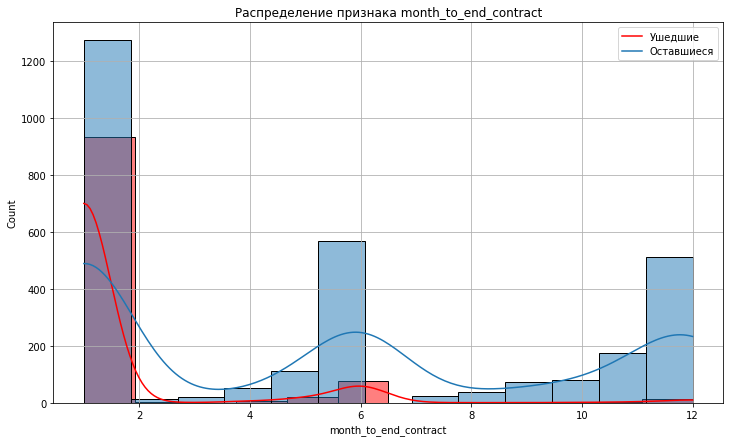

In [10]:
churn_clients = df[df['churn']==1] #Ушедшие клиенты
stayed_clients = df[df['churn']==0] #Оставшиеся клиенты

histplot_columns = ['avg_additional_charges_total', 
                    'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 
                    'lifetime', 'age', 
                    'contract_period', 
                    'month_to_end_contract']

for col in histplot_columns: 
  fig, ax = plt.subplots(figsize=(12, 7)) 
  plt.title('Распределение признака '+ col)
  sns.histplot(churn_clients[col], color="r", kde=True)
  sns.histplot(stayed_clients[col], kde=True)
  plt.legend(['Ушедшие', 'Оставшиеся'])
  plt.grid()
  plt.show()

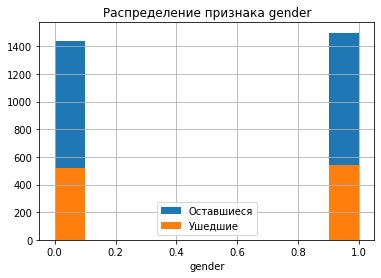

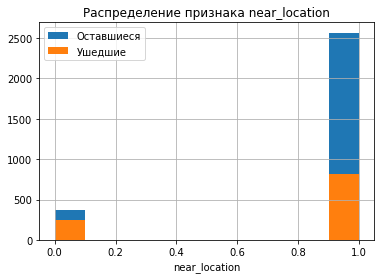

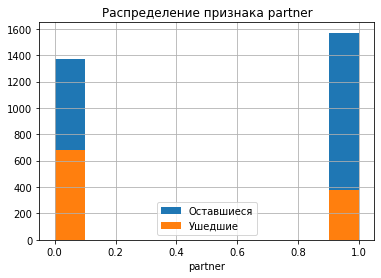

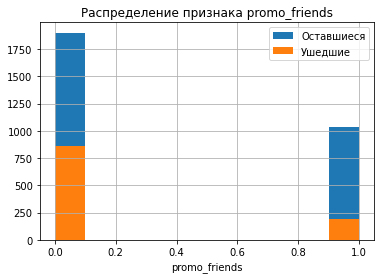

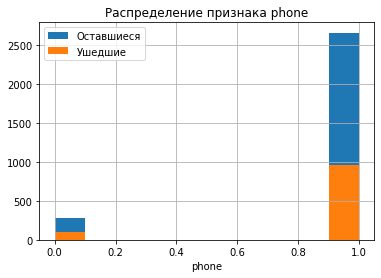

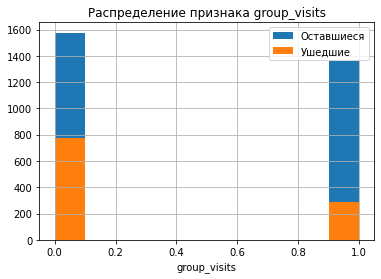

In [11]:
for col in df.drop('churn', axis = 1).columns:
  if col not in histplot_columns:
    plt.title('Распределение признака '+ col)
    plt.xlabel(col)
    df.groupby('churn')[col].hist()
    plt.legend(['Оставшиеся', 'Ушедшие'])
    plt.show()

По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.

Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. В группе лояльных клиентов число имеющих отношение к компании-партнёра сотрудников явно больше, чем среди тех, кто уходит в отток. Различия в распределении групп по посещению групповых занятий такие же, как и в распределениях по принадлежности к компании-партнёру.

Среди тех, кто остался, по промо-акции "Приведи друга" клиентов немного больше, но распределения схожи.

Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.

По среднему возрасту обе группы имеют нормальное распределение, но датасет лояльных клиентов немного смещён вправо, а датасет ушедших клиентов - влево.

Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре.

Распределение времени с момента первого обращения для обоих групп похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения.

Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.

### Матрица корреляций  <a id='blok_24'></a>

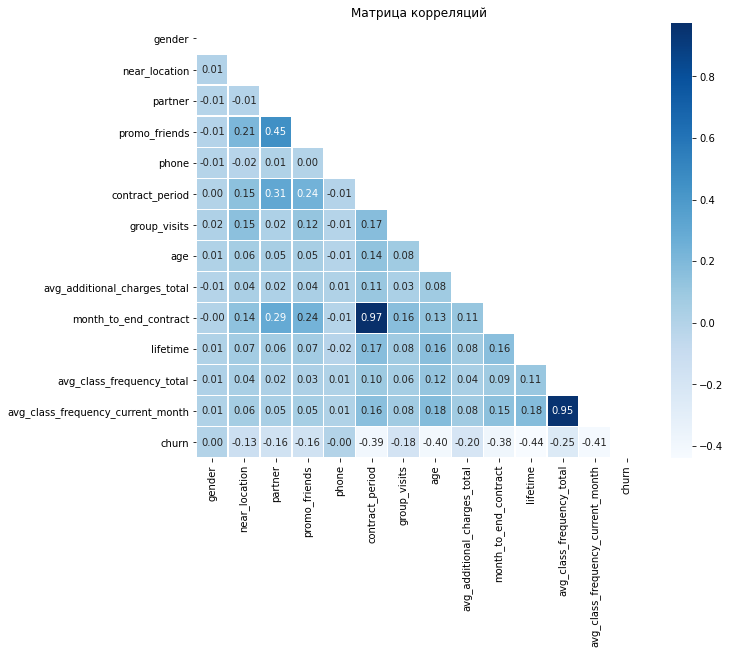

In [12]:
#Построим матрицу корреляций и отобразим её
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, mask=mask, annot = True, fmt = '0.2f', linewidths=.3, cmap="Blues")
plt.title('Матрица корреляций')
plt.show()

- На корреляции мы видим, что такие признаки как пол и контактный телефон не влияют на показатель оттока. Все остальные показатели имеют отрицательное влияние, причем либо слабое, либо чуть более выраженное, но максимум 0.44, что явно мало для выводов. Признаков, сильно связанных с оттоком предварительный анализ не показал.

- Также отметим наличие сильной связи между показателями длительности абонемента и количеством месяцев до конца абонемента. Вероятно, в базе клиенты, которые отобраны в начале действия своего абонемента.   

- Еще отметим сильную связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц.Тут, вероятно, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра. Для того, чтобы такие признаки не переобучали наши модел, удалим два мультиколлинеарных признака: month_to_end_contract и avg_class_frequency_total.

In [13]:
df = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

### Выводы <a id='blok_25'></a>

Исследовательский анализ данных (EDA) позволил сделать следующие выводы:

**Отток клиентов.** В выборке больше тех, кто продолжает пользоваться услугами.

**Пол клиентов.** Видим равномерное распределение пола как по всей выборке, так в сегментах ушедших и оставшихся клиентов.

**Близость к фитнес-центру.** В выборке больше тех, кто живёт или работает в районе фитнес-центра. Но сильной разницы между ушедшими и оставшимися по этому признаку нет.

**Сотрудники компании-партнёра.** Среди лояльных клиентов чуть больше половины тех, кто связан с партнёрами. А среди ушедших клиентов больше не связанных с компанией-партнёром.

**Промо-акция.** Акция "Приведи доруга" популярна. Среди лояльных количество пришедших с нее и без равно. Уходят активнне те, кто без промо-акции.

**Контактный телефон.** Информация есть почти по всем клиентам. Данный показатель не влияет на отток.

**Возраст.** Средний возраст равен 29 годам. В группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет.

**Время с первого обращения.** Среднее время с момента первого обращения 3 месяца. Среднее время с момента первого обращения для ушедших 1 месяц, а для тех, кто остался - около 5 месяцев. Привыкание важная вещь.

**Длительность абонемента.** Абонементы бывают 1,6 и 12  месяцев. Средняя длительность абонемента получилась 4-5 месяцев, но для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Владельцы полугодовых и годовых абонементов менее склонны к уходу, люди ценят свои деньги.

**Время до окончания абонемента.** В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. 

**Групповые занятия.** Посетители групповых занятий менее склонны к уходу.

**Частота посещений за весь срок.** В среднем посещают центр около 2 раз в неделю. Лояльные клиенты, в среднем, посещают центр скорее 3 раза в неделю, а ушедшие 1.

**Частота посещений за месяц.** Распределения и средние значения схожи с показателями частоты посещений за весь срок абонемента.

**Выручка от доп.услуг.** Выручка от дополнительных услуг фитнес-центра в среднем составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой. Лояльные клиенты склонны тратить больше. А те, кто уходит, стараются минимизировать затраты на дополнительные услуги.

На корреляции мы видим, что такие признаки как пол и контактный телефон не влияют на показатель оттока. Все остальные показатели имеют отрицательное влияние, причем либо слабое, либо чуть более выраженное, но максимум 0.44, что явно мало для выводов. Признаков, сильно связанных с оттоком предварительный анализ не показал

## Модель прогнозирования оттока клиентов <a id='blok_3'></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

### Разбиение данных на обучающую и валидационную выборки  <a id='blok_31'></a>

Разобьем данные на обучающую и валидационную выборку функцией train_test_split()

In [14]:
#Разделим данные на признаки (матрица x) и целевую переменную (y)
x = df.drop('churn', axis = 1)
y = df['churn']

#Разделим выборку на обучающую 80% и валидационную 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

#Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(x_train)

x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

### Обучение моделей "Логистическая регрессия" и "Случайный лес"  <a id='blok_32'></a>

#### Построим модель  способом "Логистическая регрессия"

In [15]:
#Зададим алгоритм для модели
logreg_model = LogisticRegression(random_state=0)

#Обучим модель
logreg_model.fit(x_train_st, y_train)

#Воспользуемся обученной моделью, чтобы сделать прогнозы
logreg_predictions = logreg_model.predict(x_test_st)
logreg_probabilities = logreg_model.predict_proba(x_test_st)[:,1]

#### Построим модель  способом "Случайный лес"

In [16]:
#Зададим алгоритм для модели
randfor_model = RandomForestClassifier(random_state=0)

#Обучим модель
randfor_model.fit(x_train_st, y_train)

#Воспользуемся обученной моделью, чтобы сделать прогнозы
randfor_predictions = randfor_model.predict(x_test_st)
randfor_probabilities = randfor_model.predict_proba(x_test_st)[:,1]

### Оценка метрик и сравнение моделей <a id='blok_33'></a>

In [17]:
#Напишем функцию для вывода метрики
def print_metrics(y_true, y_pred, y_proba, model_name):
    print("Метрики для модели "+model_name)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [18]:
#Вывод метрик для модели Логистическая регрессия
print_metrics(y_test, logreg_predictions, logreg_probabilities, 'Логистическая регрессия')
print()
#Вывод метрик для модели случайного леса
print_metrics(y_test, randfor_predictions, randfor_probabilities, 'Случайный лес')

Метрики для модели Логистическая регрессия
Accuracy: 0.92
Precision: 0.85
Recall: 0.84
F1: 0.84
ROC_AUC: 0.97

Метрики для модели Случайный лес
Accuracy: 0.91
Precision: 0.85
Recall: 0.77
F1: 0.81
ROC_AUC: 0.96


**ВЫВОД:**  
Мы разделили выборку на обучащую и валидационную в соотношении 80:20 и стандартизировали данные.  
Затем построили и обучили 2 модели: методом  логистической регрессии и случайного леса.

У обеих моделей хорошие показатели метрик, и каждую из них можно было бы использовать для прогноза.  
Но модель методом **логистической регрессии** проявила себя чуть лучше по показателям:  
* Accuracy: точность прогнозирования 0.92
* Precision: доля правильных ответов в пределах класса 0.85
* Recall: количесто исстино положительных результатов 0.84
* F1: обобщеная оценка метрик Precision и Recall 0.84
* ROC_AUC: 0.97 

## Кластеризация клиентов <a id='blok_4'></a>

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов)

### Стандартизация данных <a id='blok_41'></a>

In [19]:
#Зададим "стандартизатор"
scaler = StandardScaler()

#Стандартизируем данные
x_st = scaler.fit_transform(x)

### Матрица расстояний и дендрограмма <a id='blok_42'></a>

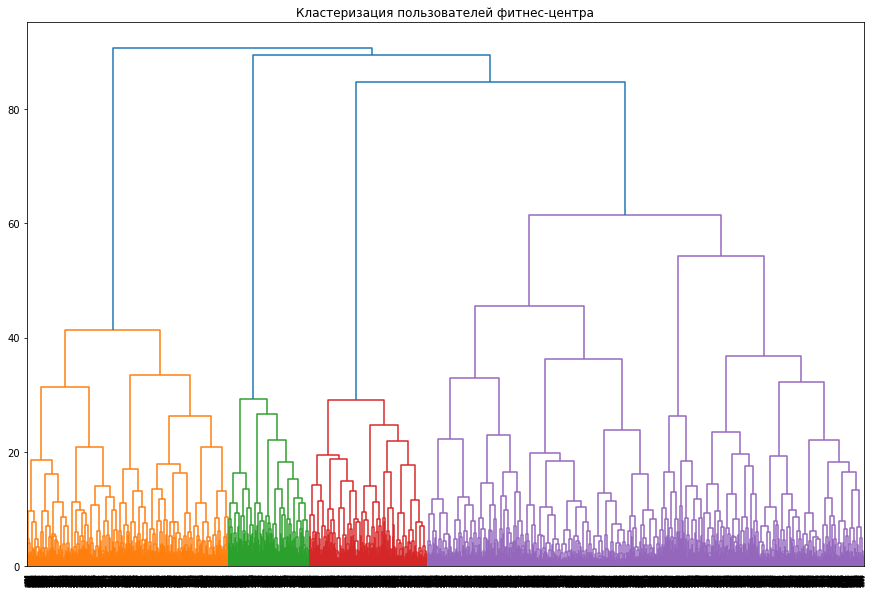

In [20]:
#Сохраним матрицу расстояний
links = linkage(x_st, method = 'ward')

#Построим дендрограмму
plt.figure(figsize=(15, 10))
plt.title('Кластеризация пользователей фитнес-центра')
dendrogram(links, orientation='top')
plt.show()

На дендрограмме выделились 4 кластера, но 1 из них потенциально можно разделить еще на несколько

### Кластеризации по алгоритму K-Means и прогнозирование кластеров клиентов <a id='blok_43'></a>

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.   
Согласно условиям проекта, за число кластеров принимаем n=5.

In [21]:
km = KMeans(n_clusters = 5, random_state = 0) #Задаём число кластеров, равное 5
labels = km.fit_predict(x_st) #Применяем алгоритм K-Means к данным и формируем вектор кластеров
df['cluster'] = labels #Добавим столбец с номерами кластеров в исходный датафрейм
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,0


### Средние значения признаков для кластеров <a id='blok_44'></a>

In [22]:
#Выведем средние значения признаков для кластеров
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


In [23]:
#Посмотрим на численность кластеров
df.cluster.value_counts()

2    1064
3    1007
0     985
1     558
4     386
Name: cluster, dtype: int64

Глядя на средние значения признаков для кластеров можно заметить, что для каждого кластера есть какие-то особенно характерные признаки: 
* **для 0 кластера** - здесь собраны клиенты, пришедшие по партнерским и дружественным абонементам и с самыми продолжительными абонементами 6мес+
* **для 1 кластера** - клиенты не живут и не работают в районе фитнес-центра
* **для 2 кластера** - клиенты с самым большим количеством уходов из сети, самым маленьким лайфтаймом и средним посещением в месяц
* **для 3 кластера** - среди них практически нет пришедших с «приведи друга», здесь самые большие значения среднего возраста клиента, лайфтайма, средней выручки от смежных услуг и самый низкий показатель оттока 
* **для 4 кластера** - самый маленький кластер, здесь собраны клиенты без номера телефона

### Распределения признаков для кластеров <a id='blok_45'></a>

Для анализа распределения признаков кластеров мы построим:
- столбчатые диаграммы для бинарных значений признаков (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первый визит по акции "Приведи друга", наличие телефона, посещение групповых занятий)   
- боксплоты для непрерывных переменных (возраст, лайфтайм, средняя частота посещений в неделю за месяц, выручка от доп.услуг)

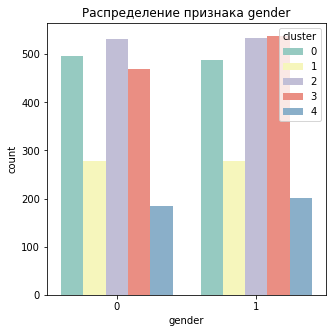

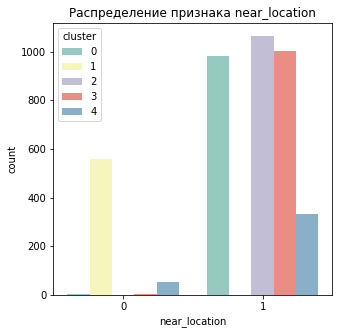

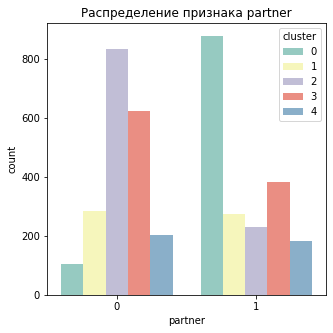

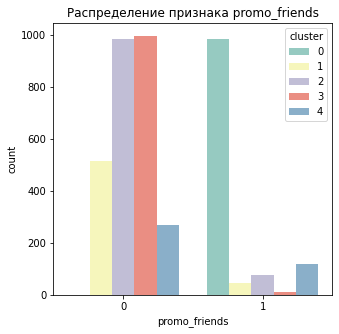

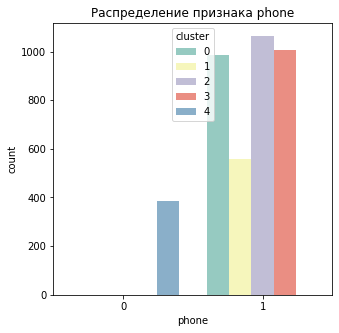

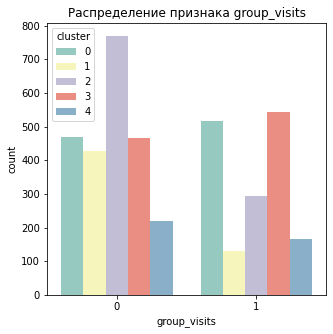

In [24]:
#Построим countplot-графики для бинарных признаков
for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    plt.title('Распределение признака '+ col)
    plt.xlabel(col)
    sns.countplot(x = df[col], hue='cluster', data=df, palette="Set3")
    plt.show()

- Кластеры идентичны по распределению такого признака как пол.  
- Кластер №1 собрал в себя почти всех, кто живет и работает далекго от фитнес-центра.
- Для Кластера №2 в большей степени характерны клиенты, пришедшие с "партнерки". А для кластера №0 этот признак максимально нехарактерен.  
- Клиенты, пришедшие с акции "приведи друга" собраны в кластере №0.
- Контктные номера телефонов известные для всех кластеров, кроме №4.
- Груповые занятие меньше всего предпочитает Кластер №2

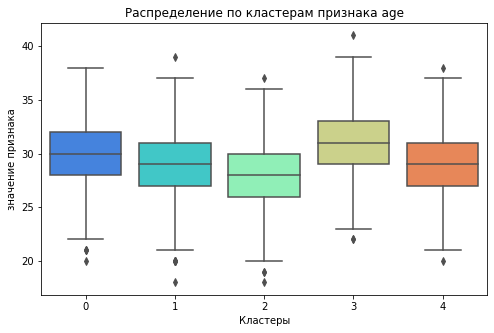

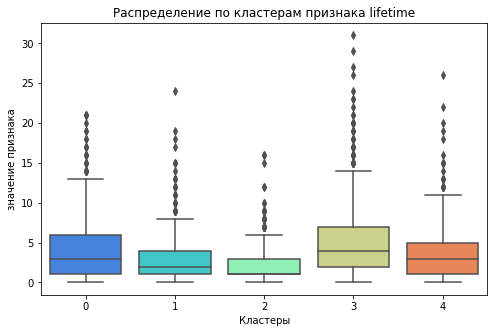

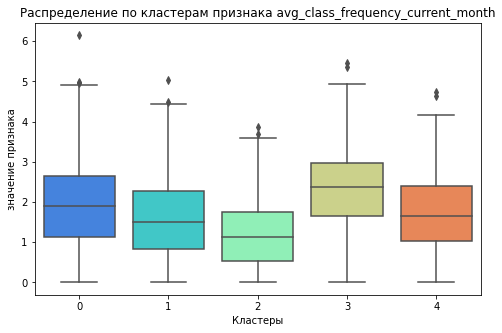

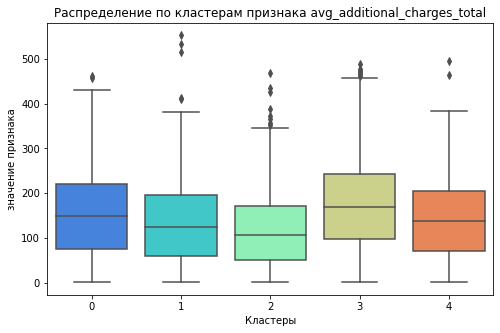

In [25]:
#Построим графики для непрерывных переменных
columns = ['age', 'lifetime','avg_class_frequency_current_month', 'avg_additional_charges_total'] #список интересующих нас признаков

for col in columns:
    plt.figure(figsize=(8, 5))
    plt.title("Распределение по кластерам признака "+col)
    sns.boxplot(x='cluster',y=col, data=df, palette="rainbow")
    plt.xlabel('Кластеры')
    plt.ylabel('значение признака')
    plt.show()

- Средний возраст примерно одинаковый, но чуть выше в кластере №3 тут же самые возрастные клиенты. И чуть ниже в кластере №2, тут можно встретить самых юных спортсменов.
- Самый продолжительный фитнес стаж в кластере №3, среднее значение лайфтайма тут тоже выше остальных кластеров. А вот в кластере №2 ровно наоборот.
- Чаще всего в среднем в зал ходят в кластере №3 (почти 3 раза в неделю), реже всего в кластере №2. Можно отметить, что в кластере №0 встречаются случаи 6 разового посещения центра.
- Большую выручку в среднем приносит кластер №3. Хотя некотрые клиенты из кластеров №2 и №1 тоже оставляют большие суммы на допуслуги. Не ходить на фитнес и групповые тренировки, но посещать солярий и хамам это вполне возможно))

### Доли оттока в кластерах <a id='blok_46'></a>

Для каждого полученного кластера посчитаем долю оттока.  
Посмотрм, отличаются ли они по доле оттока. Какие кластеры склонны к оттоку, а какие — надёжны.

In [26]:
print('Доля ушешдих клиетов в {} \n'.format( df.groupby('cluster')['churn'].mean()))

#Так как количество клиентов в кластерах неодинаковое, то нужно смотреть распределение оттока относительно всех клиентов
print('Доля ушедших клиентов приходяшихся на {} '.format(df.groupby('cluster')['churn'].sum()/df['churn'].sum()))

Доля ушешдих клиетов в cluster
0    0.119797
1    0.403226
2    0.563910
3    0.014896
4    0.266839
Name: churn, dtype: float64 

Доля ушедших клиентов приходяшихся на cluster
0    0.111216
1    0.212064
2    0.565504
3    0.014138
4    0.097078
Name: churn, dtype: float64 


Самый большой отток клиентов идет по кластеру №2 - 56.5% и по кластеру №1 - 21%.  
Самые лояльные клиенты из кластера №3, тут отток чуть меньше 1.5%

### Выводы <a id='blok_47'></a>

Нам удалось стандартизировать базу клиентов, построить матрицу расстояний и дендрограмму, провести кластеризацию по алгоритму K-Means и определить 5 кластеров с характерными особенностями признаков и проанализировать показатели оттока по каждому кластеру.   

Обнаружить какого-то признака сильно влияющего на отток клиентов фитнес-центра не удалось. Но мы заметили, что те кто редко посещает фитнес и у кого небольшая продолжительность абонемента более склонны к оттоку. А те кто покупает абонементы на больший срок 6-12 месяцев, ходит на занятия чаще, посещает групповые тренировки и тратится на доп.услуги менее склонны к уходу.

##  Выводы <a id='blok_5'></a>

Сформулируем основные выводы и предложим рекомендации для стратегии взаимодействия с клиентами и их удержания.

### Общие выводы <a id='blok_51'></a>

База данных была в хорошем состоянии и практически не требовала корректировок.  

Построенные модели прогнозирования оттока клиентов были созданы способами "Логистическая регрессия" и "Случайный лес", обе из которых показали хорошие результаты и могут использовать в дальнейшей аналитической работе центра.

Кластеризация позволила определить 5 групп с характерными особенностями признаков и проанализировать показатели оттока по каждой. В результате анализа кластеров у нас есть **портрет идеального клиента**: 
- возраст около 30 лет
- живет или работает недалеко от фитнес-центра
- посещает групповые занятия
- есть друзья, которые тоже посещают этот фитнес-центр
- есть скидки/бонусы по каким-то партнерским программам
- абонемент на 6 или 12 месяцев
- пользуется дополнительными услугами центра (бар, солярий, массаж, спорттовары).

### Рекомендации <a id='blok_52'></a>

Менеджерам необходимо склонять клиентов к покупке абонементов с большим сроком, возможно маркетологам стоит разработать дополнительные стимулирующие акции или вдохновляющие промо.  

Новых клиентов необходимо в первое время особенно опекать и уделять повышенное внимание, стимулируя к более частому посещению и групповым занятиям.  

Необходимо простимулировать у клиентов пользование допуслугами центра. особенно у новеньких. Возможно предложить скидки или вообще бесплатные первые коктейли, посещения соляриев, массажа и тд.  

Партнерские программы и промо-акции дают лояльных клиентов, можно продолжать работать в этом направлении.   

Также стоит продолжить привлекать клиентов живущих и работающих в непосредственной близости к фитнес-центру (активне использовать геотаргетинг в интеренет реклами, чтоб тратить бюджет на определенную локацию, возможно реклама в лифтах и листовки)